# Quién es quién en los precios 

Este cuaderno de python busca proporcionar el código necesario para responder a ciertas preguntas de interés usando la base de datos que ya hemos limpiado en los pasos anteriores. Los datos se encuentran en S3 y todo se corre en spark. Se adjuntan las imágenes de los resultados obtenidos al correr el código en el cluster de EMR. 

#### Creando la sesión de spark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, col, countDistinct, count, row_number, max as max_, col, min as min_
from pyspark.sql.window import Window

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("Proyecto Parcial Arquitectura") \
    .getOrCreate()

Cargando los datos

In [ ]:
df3 = spark.read.option("delimiter", "|").option("header", True).csv("combined_with_names_fixed.csv")

df3.printSchema()

1. Guardar el CSV como parquet en S3, particionalo por catalogo

In [ ]:
df3.write.partitionBy("catalogo").parquet("parquets/df_por_catalogo")

2. Carga el parquet en Spark

In [ ]:
df_parquet = spark.read.parquet("parquets/df_por_catalogo")

¿Cuántos catálogos diferentes tenemos? (por año)

In [ ]:
from pyspark.sql.functions import year, col, countDistinct

df_parquet = df_parquet.withColumn("Year", year(col("fecharegistro").cast("date")))
df_parquet = df_parquet.withColumn("Year", year("fecharegistro"))

# Count unique catalogo by Year
unique_counts = df_parquet.groupBy("Year").agg(countDistinct("catalogo").alias("UniqueCatalogo"))

# Show the results
unique_counts.show()

Y obtenemos:

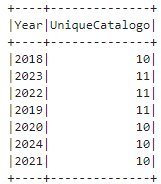

¿Cuáles son los 20 catálogos con más observaciones? Guarda la salida de este query en tu bucket de S3, lo necesitaremos más adelante.

Para esta pregunta usamos el top 5 pero dejamos la posibilidad de cambiar el parámetro para obtener los n catálogos con más observaciones.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, row_number
from pyspark.sql.window import Window

# Realizar la agrupación por 'catalogo' y 'Year', y calcular el conteo
catalogos_populares = df_parquet.groupBy("catalogo", "Year").agg(count("*").alias("Conteo"))

# Definir una ventana particionada por año y ordenada por el conteo descendente
windowSpec = Window.partitionBy("Year").orderBy(col("Conteo").desc())

# Aplicar row_number sobre cada partición de la ventana para obtener los rankings
catalogos_populares = catalogos_populares.withColumn("row_num", row_number().over(windowSpec))

# Filtrar para obtener los top N catálogos por año
top_n = 5  # Define cuántos top catálogos quieres obtener
top_catalogos_populares = catalogos_populares.filter(col("row_num") <= top_n).drop("row_num")

# Mostrar los resultados finales
top_catalogos_populares.show()


¿Tenemos datos de todos los estados del país? De no ser así, ¿cuáles faltan?

In [ ]:
from pyspark.sql.functions import col

# Extraer los estados distintos
df_estados = df_parquet.select("estado").distinct()

# Contar registros por estado
df_estados_presentes = df_parquet.select("estado", "Year").distinct()

# Extraer todos los años distintos presentes en df_parquet
df_anos = df_parquet.select("Year").distinct()

# Crear todas las combinaciones posibles de estados y años
df_combinaciones = df_estados.crossJoin(df_anos)

# Realizar un left anti join para encontrar las combinaciones que no están en los datos presentes
estados_faltantes = df_combinaciones.join(df_estados_presentes, ["estado", "Year"], "left_anti")

# Mostrar los estados faltantes por año
estados_faltantes.show()


¿Cuántas observaciones tenemos por estado?

In [ ]:
df_conteo_estado_anio = df_parquet.groupBy("Year", "estado").agg(count("*").alias("Conteo"))
df_conteo_estado_anio.show()

Para cada año, de cada estado obten: el número de catalogos diferentes por año, ¿ha aumentado el número de catálogos con el tiempo?

In [ ]:
df_catalogos_anio = df_parquet.groupBy("Year", "catalogo").agg(count("*").alias("Conteo"))

### Para el catálogo de "frutas y legumbres procesadas"

¿Cuańtas marcas diferentes tiene tu categoría? Para esta pregunta se toma la columna de "producto" como marca, ya que al ser frutas, carecen de marca. De modo que las preguntas que hagan referencia a marcas, se refieren a frutas o legumbres.

In [ ]:
df_marcas_distintas= df_parquet.filter(df_parquet["catalogo"]=="frutas y legumbres procesadas").select("producto").distinct()
df_marcas_distintas.show()

¿Cuál es la marca con mayor precio? ¿En qué estado?
Para cada año, nos traemos las frutas y legumbres más caras y el estado en el que se venden

In [ ]:
from pyspark.sql.functions import max as max_, col

# Suponemos que df_parquet ya está definido y hemos filtrado por "frutas y legumbres"
df_frutas_legumbres = df_parquet.filter(col("catalogo") == "frutas y legumbres")

# Asumimos que ya has definido el DataFrame df_frutas_legumbres y que tiene una columna "Year"
# Agrupar por año y encontrar el precio máximo en cada año
max_precios_por_ano = df_frutas_legumbres.groupBy("Year").agg(max_("precio").alias("max_precio"))

# Ahora usamos alias para cada DataFrame antes del join para evitar ambigüedades
df_frutas_legumbres_alias = df_frutas_legumbres.alias("frutas_legumbres")
max_precios_por_ano_alias = max_precios_por_ano.alias("max_precios")

# Hacer join entre el DataFrame de precios máximos por año y el DataFrame original
df_marca_max_precio = max_precios_por_ano_alias.join(
    df_frutas_legumbres_alias,
    (col("max_precios.Year") == col("frutas_legumbres.Year")) & 
    (col("max_precios.max_precio") == col("frutas_legumbres.precio")),
    "inner"
)

# Seleccionar los datos relevantes del join, evitando ambigüedades
df_marca_max_precio = df_marca_max_precio.select(
    col("frutas_legumbres.Year"),
    col("frutas_legumbres.producto"),
    col("frutas_legumbres.estado"),
    col("frutas_legumbres.precio")
).distinct()

# Mostrar resultados
df_marca_max_precio.show()

¿Cuál es la marca con menor precio en CDMX? (en aquel entonces Distrito Federal)

In [ ]:
from pyspark.sql.functions import min as min_

df_frutas_legumbres = df_parquet.filter(col("catalogo") == "frutas y legumbres").filter(col("estado")=='ciudad de mexico')

# Asumimos que ya has definido el DataFrame df_frutas_legumbres y que tiene una columna "Year"
# Agrupar por año y encontrar el precio máximo en cada año
min_precios_por_ano = df_frutas_legumbres.groupBy("Year").agg(min_("precio").alias("min_precio"))

# Ahora usamos alias para cada DataFrame antes del join para evitar ambigüedades
df_frutas_legumbres_alias = df_frutas_legumbres.alias("frutas_legumbres")
min_precios_por_ano_alias = min_precios_por_ano.alias("min_precios")

# Hacer join entre el DataFrame de precios máximos por año y el DataFrame original
df_marca_max_precio = min_precios_por_ano_alias.join(
    df_frutas_legumbres_alias,
    (col("min_precios.Year") == col("frutas_legumbres.Year")) & 
    (col("min_precios.min_precio") == col("frutas_legumbres.precio")),
    "inner"
)

# Seleccionar los datos relevantes del join, evitando ambigüedades
df_marca_max_precio = df_marca_max_precio.select(
    col("frutas_legumbres.Year"),
    col("frutas_legumbres.producto"),
    col("frutas_legumbres.estado"),
    col("frutas_legumbres.precio")
).distinct()

# Mostrar resultados
df_marca_max_precio.orderBy(col("Year").asc()).show()

In [ ]:
# si solo queremos el producto de menor precio de todos los años
df_frutas_legumbres = df_parquet.filter(col("catalogo") == "frutas y legumbres").filter(col("estado")=='ciudad de mexico')

# Definir la especificación de la ventana para particionar por 'estado' y 'Year', y ordenar por 'precio'
windowSpec = Window.partitionBy().orderBy(col("precio").asc())

# Aplicar la función de ventana para asignar un número de fila dentro de cada partición
df_frutas_legumbres = df_frutas_legumbres.withColumn("row_num", row_number().over(windowSpec))

# Filtrar los registros donde el número de fila es 1, indicando el precio más bajo en cada grupo
df_min_precio = df_frutas_legumbres.filter(col("row_num") == 1).drop("row_num")

# Mostrar los resultados
df_min_precio.select("Year", "producto", "precio").show()

¿Cuál es la marca con mayores observaciones?

In [ ]:
df_conteo_producto = df_parquet\
    .filter(col("catalogo")=="frutas y legumbres")\
    .groupBy("producto")\
    .agg(count("*").alias("Conteo"))\
    .orderBy(col("Conteo").desc())\
    .limit(1)

df_conteo_producto.show()

¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Son diferentes?

In [ ]:
df_frutas_legumbres = df_parquet.filter(col("catalogo") == "frutas y legumbres")

# Definir la especificación de la ventana para particionar por 'estado' y 'Year', y ordenar por 'precio' descendente
windowSpec = Window.partitionBy("estado", "Year").orderBy(col("precio").desc())

# Agregar un número de fila dentro de cada partición de estado y año
df_frutas_legumbres = df_frutas_legumbres.withColumn("row_number", row_number().over(windowSpec))

# Filtrar por los top 5 productos con mayor precio en cada estado y año
top_5_por_estado_y_ano = df_frutas_legumbres.filter(col("row_number") <= 5)

# Seleccionar las columnas relevantes para la visualización
top_5_por_estado_y_ano = top_5_por_estado_y_ano.select("Year", "estado", "producto", "precio", "row_number")

# Mostrar los resultados ordenados por estado y año para una mejor visualización
top_5_por_estado_y_ano.orderBy("estado", "Year", "row_number").show()

¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal)

In [ ]:
df_frutas_legumbres = df_parquet.filter(col("catalogo") == "frutas y legumbres")\
    .filter(col("estado")=="ciudad de mexico")

# Definir la especificación de la ventana para particionar por 'estado' y 'Year', y ordenar por 'precio' descendente
windowSpec = Window.partitionBy("Year").orderBy(col("precio").asc())

# Agregar un número de fila dentro de cada partición de estado y año
df_frutas_legumbres = df_frutas_legumbres.withColumn("row_number", row_number().over(windowSpec))

# Filtrar por los top 5 productos con mayor precio en cada estado y año
top_5_por_estado_y_ano = df_frutas_legumbres.filter(col("row_number") <= 5)

# Seleccionar las columnas relevantes para la visualización
top_5_por_estado_y_ano = top_5_por_estado_y_ano.select("Year", "estado", "producto", "precio", "row_number")

# Mostrar los resultados ordenados por estado y año para una mejor visualización
top_5_por_estado_y_ano.orderBy("estado", "Year", "row_number").show()

¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado?

In [ ]:
df_marcas = df_parquet\
    .filter(col("catalogo")=="frutas y legumbres")\
    .groupBy("producto")\
    .agg(count("*").alias("conteo"))\
    .orderBy(col("conteo").desc())\
    .limit(5)

df_marcas.show()

¿Ha dejado de existir alguna marca durante los años que tienes? ¿Cuál? ¿Cuándo desapareció?

In [ ]:
df_marcas_desaparecidas = df_parquet\
    .filter(col("catalogo")=="frutas y legumbres")\
    .groupBy("producto")\
    .agg(min_("Year").alias("primer_aparicion"), max_("Year").alias("ultima_aparicion"))

df_marcas_desaparecidas.filter(col("ultima_aparicion")<2024).show()

Genera una gráfica de serie de tiempo por estado para la marca con mayor precio -en todos los años-, donde el eje equis es el año y el eje ye es el precio máximo.